In [ ]:
#Mounts your google drive into this virtual machine

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install mne

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,corrmap)
from sklearn.cross_decomposition import CCA
from scipy.signal import butter, lfilter, periodogram
from scipy.fft import fft, fftfreq, ifft
import scipy.io as sio

# **Offline SSVEP data visualization and processing**

In [ ]:
#General Data Path
data_path = "/content/drive/MyDrive/YOURPATH/SharedPublicly/Data/SSVEP_EEG"
#Single User Data Path
single_user = "/content/drive/MyDrive/YOURPATH/SharedPublicly/Data/SSVEP_EEG/s0/s0_1657_100621.mat"
SSVEP_mat = sio.loadmat(single_user)

In [ ]:
#Function that performs the filtering and epoching of the SSVEP data
def SSVEP_epoching(SSVEP_eeg):
    '''
    SSVEP_eeg: dict, dictionary loaded from EEG_SSVEP

    returns: mne.Epochs object with the filtered SSVEP data epoched, and list of marker_labels
            indicating the frequency that corresponds to each epoch
    '''
    timestamps = SSVEP_eeg['SSVEP_continuous_timestamps'][0]
    eeg_data = SSVEP_eeg['SSVEP_continuous'][:,-10:].T/(10**6)

    chan_names = ['Fp1', 'Fp2', 'Fz', 'Cz', 'Pz', 'Oz', 'PO3', 'PO4', 'O1', 'O2']
    ch_types = ['eeg'] * len(chan_names)
    custom_montage = mne.channels.make_standard_montage('standard_1005')

    sfreq = 250
    info = mne.create_info(ch_names=chan_names, sfreq=sfreq, ch_types=ch_types)
    info.set_montage(custom_montage)
    raw = mne.io.RawArray(eeg_data, info)
    raw.filter(5,50)
    raw.notch_filter(np.arange(60, 125, 60))
    raw.set_montage(custom_montage)
    raw.set_eeg_reference(ref_channels='average')
    
    marker_stamps = SSVEP_eeg['Marker_timestamps'].flatten()#[:-1]
    marker_names = SSVEP_eeg['Marker_samples'].flatten().astype(int).astype(str)#[:-1]
    choose_marker = {f'{n}':i for i,n in enumerate(np.unique(marker_names))}
    marker_labels = [choose_marker[i] for i in marker_names]

    #Create events array
    events = np.zeros((1,3),dtype=np.int64) #int64?
    start_time = timestamps[0]*sfreq #Get start index
    eeg_stamps = timestamps
    print(marker_stamps)

    for i in range(len(marker_stamps)):
        mark_t = marker_stamps[i] #Get the time stamps of marker number i
#         print(mark_t)
        epoch_bool = np.where(eeg_stamps > mark_t,True,False)
        try:
            idx_time = timestamps[epoch_bool][0].item()*sfreq #Get index where current time-stamp occurs
        except:
            print("Marker_stamp: ", mark_t," Bool", epoch_bool)
        marker_label = marker_labels[i]
        new_event = np.array([round(idx_time-start_time),0,int(marker_label)]) #Make array of (idx at event,0,marker_label)
        events = np.vstack((events,new_event))
    events = events[1:]
    
    tmax = 10.
    tmin = -0.1
    picks = list(range(2,10))
    print(choose_marker)
    raw_epochs = mne.Epochs(raw,events,event_id=choose_marker,picks=picks,tmin=tmin,tmax=tmax) #Specify picks to select specific channels
    return (raw_epochs,marker_labels)

## Plot of SSVEP Power Spectrum Across Single User

In [ ]:
#Plot of average power spectral density across relevant channels for user s0
raw_epochs,marker_labels = SSVEP_epoching(SSVEP_mat)

fmin = 14
fmax = 26
tmin = 2. #Original is 1.
tmax = 10. #Originl is 10.
fig, ax = plt.subplots(4,2,sharex=True, sharey=True)
fig_idx = 0
sfreq = 250
row = 0
epoch_avg = 4 #Number of epochs to average over
freq_list = [16,17,18,19,20,21,22,23]

for freq in [f'{i}' for i in range(8)]:
    if freq != '100':
        psds, freqs = mne.time_frequency.psd_welch(
            raw_epochs[f'{freq}'],
            n_fft=int(sfreq * (tmax - tmin)),
            n_overlap=0, n_per_seg=None,
            tmin=tmin, tmax=tmax,
            fmin=fmin, fmax=fmax,
            window='boxcar',
            verbose=False)
        spds_plot = 10*np.log10(psds[:epoch_avg,:,:])
        spds_mean = spds_plot.mean(axis=(0,1))
        ax[row,fig_idx%2].plot(freqs,spds_mean)
        ax[row,fig_idx%2].text(0.95, 0.95, f'@ {freq_list[int(freq)]} Hz', horizontalalignment='right',
                              verticalalignment='top', transform=ax[row,fig_idx%2].transAxes)
        if row == int(len(freq_list)/2-1):
            ax[row,fig_idx%2].set(xlabel='Frequency (Hz)')
        ax[row,fig_idx%2].vlines(float(freq_list[int(freq)]),ymin=np.min(spds_mean), ymax=np.max(spds_mean),colors='r')
        plt.grid()
        if fig_idx % 2 != 0:
            row += 1
        fig_idx += 1
plt.tight_layout(pad=1.5)
fig.text(0.04, 0.5, 'PSD (dB)', va='center', rotation='vertical')
fig.text(0.5, 0.98, 'PSD vs. Stimulus Frequency', ha='center')

## Plot of CCA Analysis Across All users

In [ ]:
def CCA_accuracy_assess(raw_epochs,marker_labels,freq_list = [16,17,18,19,20,21,22,23]):
  '''
  raw_epochs: mne.Epochs, the epoched and processed EEG data
  marker_labels: list, marker label for each epoch
  freq_list: list, frequencies of stimuli

  return: array, CCA accuracy across different window sizes [1,2,3,4,5] seconds
  '''
  sfreq = 250

  wind_accuracy = []
  CCA_weights_save = []
  for WINDOW_SIZE in [250,500,750,1000,1250]:
      Y_f = [] #Sinusoids generated to run CCA

      for f in freq_list:
          Y_fsin = np.sin([2*np.pi*f*n/sfreq for n in range(WINDOW_SIZE)])
          Y_fsin2 = np.sin([2*np.pi*(2*f)*n/sfreq for n in range(WINDOW_SIZE)])
          Y_fcos = np.cos([2*np.pi*f*n/sfreq for n in range(WINDOW_SIZE)])
          Y_fcos2 = np.cos([2*np.pi*(2*f)*n/sfreq for n in range(WINDOW_SIZE)])
          Y_f.append(np.vstack([Y_fsin,Y_fcos,Y_fsin2,Y_fcos2]).T) #This stimulus already has mean zero, but any other stimulus should as well

      predictions = []

      for batch in raw_epochs:
          batch = batch[:,int(2*sfreq):int(2*sfreq) + WINDOW_SIZE].T
          score_list = []
          for n in range(len(freq_list)):
              cca = CCA(n_components = 1)
              cca.fit(batch,Y_f[n][:,0:2])
              CCA_weights_save.append(cca.x_weights_)
              X_c, Y_c = cca.transform(batch, Y_f[n][:,0:2])
              corr1 = np.corrcoef(X_c[:,0],Y_c[:,0])[0,1]
              score_list.append(corr1)
          predictions.append(np.argmax(score_list))

      accuracy_bool = np.array(predictions) == np.array(marker_labels)
      accuracy = sum(accuracy_bool)/len(accuracy_bool)
      wind_accuracy.append([accuracy,WINDOW_SIZE/250])
  return np.array(wind_accuracy)

In [ ]:
#Aggregating Data from all users
users = [f's{i}' for i in range(7)]
accuracies_list = []
for user in users:
  trial_path = data_path + f"/{user}/"
  for file, direct, d in os.walk(trial_path):
    if file == trial_path:
      print(d)
      for sub_f in d:
        if sub_f.endswith("mat"):
          print(sub_f)
          new_SSVEP_mat = sio.loadmat(f'{file}/{sub_f}')
          (raw_epochs,marker_labels) = SSVEP_epoching(new_SSVEP_mat)
          accuracies_list.append(CCA_accuracy_assess(raw_epochs,marker_labels).squeeze())
accuracy_ar = np.array(accuracies_list)[:,:,0]
avg_accuracy = np.mean(accuracy_ar,axis=0)
time_winds = np.array(accuracies_list)[:,:,1][0,:]

['s0_1657_100621.mat']
s0_1657_100621.mat
s0_1657_100621.mat
Creating RawArray with float64 data, n_channels=10, n_times=98831
    Range : 0 ... 98830 =      0.000 ...   395.320 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

Text(0.5, 0, 'Window Size')

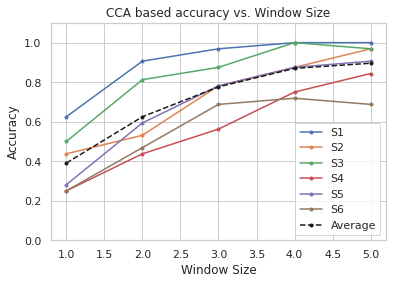

In [ ]:
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

CCA_accuracy = avg_accuracy
CCA_wind_size = time_winds.flatten()
plt.figure()
yerr = np.square(accuracy_ar - np.mean(accuracy_ar,axis=0)).mean(axis=0)
for i in range(6):
    plt.plot(CCA_wind_size,accuracy_ar.T[:,i],marker='.',label=f"S{i+1}")
plt.plot(CCA_wind_size,avg_accuracy,color="k",linestyle="dashed",label="Average",marker='.')
plt.legend()
plt.ylim([0,1.1])
plt.title("CCA based accuracy vs. Window Size")
plt.ylabel("Accuracy")
plt.xlabel("Window Size")

### Signal Validation

In [126]:
#Agreggating SNR Results

users = [f's{i}' for i in range(7)]
snr_list_all = []
snrdB_list_all = []
for user in users:
  trial_path = data_path + f"/{user}/"
  for file, direct, d in os.walk(trial_path):
    if file == trial_path:
      print(d)
      for sub_f in d:
        if sub_f.endswith("mat"):
            print(sub_f)
            new_SSVEP_mat = sio.loadmat(f'{file}/{sub_f}')
            (raw_epochs,marker_labels) = SSVEP_epoching(new_SSVEP_mat)
            reg_snr, dB_snr = snr_calculator(raw_epochs)
            snr_list_all.append(reg_snr)
            snrdB_list_all.append(dB_snr)

*******************direct:  ['Bad'] d:  Nelson_1657_100621.mat
Creating RawArray with float64 data, n_channels=10, n_times=98831
    Range : 0 ... 98830 =      0.000 ...   395.320 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference

In [141]:
#Compute Mean SNR Value:
np.mean(snr_list_all)

4.286977986389853

In [142]:
#Compute Mean SNR Value based on dB scale:
np.mean(np.array(snrdB_list_all))

11.761568749343345

In [28]:
#ITR Calculation
def ITR(P,T,N=8):
    return 60/T*(np.log2(N)+P*np.log2(P)+(1-P)*np.log2((1-P)/(N-1)))

for i,p in enumerate(np.mean(accuracy_ar,axis=0)):
    print("Window size: ",i,"Accuracy: ",p)
    print("ITR: ", ITR(p,(i+1),N=8))

Window size:  0 Accuracy:  0.390625
ITR:  19.443983737264887
Window size:  1 Accuracy:  0.625
ITR:  29.78423703910301
Window size:  2 Accuracy:  0.7760416666666666
ITR:  32.078795022303474
Window size:  3 Accuracy:  0.8697916666666666
ITR:  31.14674596856506
Window size:  4 Accuracy:  0.8958333333333334
ITR:  26.706012570430875
